# Sarcasm Detection Using XGBoost and Logistic Regression

In [1]:
########
#some eda from https://www.kaggle.com/danofer/loading-sarcasm-data
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
from matplotlib import pyplot as plot
import os
import numpy as np
import xgboost
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import preprocessing, metrics, svm

##Data Exploration

Repeating a portion of the data exploration from YURY KASHNITSKY: https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit-solution

(1010826, 10)
Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')


['Oh sure, the *black* duck has to be the angry one...',
 "I'm sure they'll outlive the new Domino's that's going in.",
 "I bet it's Seager.",
 'How dare you post a shot of your computer while actually using it!',
 'Because its not like the breaks are there for stopping or anything.',
 'Screw this computer, it doesnt even have a Touchbar',
 'Yes however we retain a modicum of culture',
 'Nah, google + integration is better.',
 "because they haven't been competitive all year long",
 'But if they do, rents will become unaffordable... oh wait, right, never mind.']

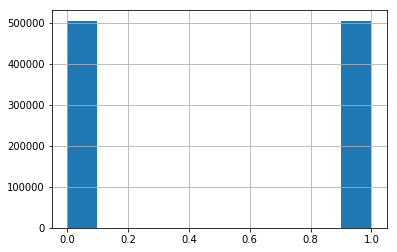

In [2]:
train = pd.read_csv("C:/Users/kevin/Desktop/Career Prep/Kevin work Portfolio/Personal Project/sarcasm/train-balanced-sarcasm.csv")
print(train.shape)
print(train.columns)

#drop rows that have missing comments
train.dropna(subset=['comment'], inplace=True)

# Parse UNIX epoch timestamp as datetime: 
train.created_utc = pd.to_datetime(train.created_utc,infer_datetime_format=True) # Applies to original data , which had UNIX Epoch timestamp! 

train.describe()

########
train['label'].hist() #50 50 split

##see a sample of comments
train['comment'].sample(10)
train[train.label == 1]["comment"].sample(10).tolist()

In [3]:
#how many comments are in each subreddit?
train.groupby(["subreddit"]).count()["comment"].sort_values()

#learn more about the subreddits and the frequency of sarcastic labels
sub_df = train.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

#learn more about authors and the frequency of sarcastic labels
author_df = train.groupby('author')['label'].agg([np.size, np.mean, np.sum])
author_df.sort_values(by='sum', ascending=False).head(10)
author_df[author_df['size'] > 250].sort_values(by='mean', ascending=False).head(10)


,size,mean,sum
author,,,
Canada_girl,300,0.500000,150
Chaoslab,252,0.500000,126
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


In [4]:
#split the df into training and validation parts
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train['comment'], train['label'], random_state=17)
        
print(train_texts.shape, valid_texts.shape, y_train.shape, y_valid.shape)

'''
#take small sample for testing
train_texts_small = train_texts.sample(600, random_state=27)
y_train_small = y_train.sample(600, random_state=27)
valid_texts_small = valid_texts.sample(600, random_state=27)
y_valid_small = y_valid.sample(600, random_state=27)
'''



(758079,) (252694,) (758079,) (252694,)


'\n#take small sample for testing\ntrain_texts_small = train_texts.sample(600, random_state=27)\ny_train_small = y_train.sample(600, random_state=27)\nvalid_texts_small = valid_texts.sample(600, random_state=27)\ny_valid_small = y_valid.sample(600, random_state=27)\n'

##Preprocessing with NLTK

Porter Stemming was inspired by the following source: 
https://medium.com/@chrisfotache/text-classification-in-python-pipelines-nlp-nltk-tf-idf-xgboost-and-more-b83451a327e0

The classifier function's source is the following: 
https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [5]:
%%time
#Consider porter stemming
import nltk, re
def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    #words = re.search(r'\w{1,}',str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words


def train_model(classifier, feature_vector_train, label, feature_vector_valid, label_valid,is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, label_valid)
    return metrics.classification_report(predictions, label_valid)


#count vectors
'''
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 3), max_features=50000, min_df=2, lowercase=True, max_df=0.9)
count_vect.fit(train['comment'])

#count vectors
# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_texts)
xvalid_count =  count_vect.transform(valid_texts)
'''

# word and n-gram level tf-idf
#tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=50000, ngram_range=(1,3), min_df=2, lowercase=True, max_df=0.9)
tfidf_vect = TfidfVectorizer(analyzer='word', tokenizer=Tokenizer, max_features=50000, ngram_range=(1,2), min_df=2, lowercase=True, max_df=0.95)
tfidf_vect.fit(train['comment'])
xtrain_tfidf =  tfidf_vect.transform(train_texts)
xvalid_tfidf =  tfidf_vect.transform(valid_texts)

Wall time: 23min 42s


##XGBoost Classifier

In [6]:
%%time
#try XGBoost on word- and ngram-level vectors
#accuracy = train_model(xgboost.XGBClassifier(), xtrainSVD, y_train, xvalidSVD)
accuracy = train_model(xgboost.XGBClassifier(n_estimators=400), xtrain_tfidf.tocsc(), y_train, xvalid_tfidf.tocsc(), y_valid)
print("Xgb, WordLevel TF-IDF: ", accuracy)

#try XGBoost on count vectors
#accuracy = train_model(xgboost.XGBClassifier(n_estimators=400), xtrain_count.tocsc(), y_train, xvalid_count.tocsc())
#print("Xgb, Count Vectors: ", accuracy)


Xgb, WordLevel TF-IDF:  0.6766800952931213
Wall time: 10min 23s


##Logistic Regression Classifier

In [9]:
%%time
#logistic regression
accuracy = train_model(LogisticRegression(solver='lbfgs', random_state=17, max_iter=1000), xtrain_tfidf, y_train, xvalid_tfidf, y_valid)
print("Logistic Regression: ", accuracy)



Logistic Regression:  0.7227080975408993
Wall time: 47.8 s
